In [1]:
from model import SegmentationModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SegmentationModel()
model.to(device)

print(model)

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
SegmentationModel(
  (model): SegmentationNet(
    (enc1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (enc2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (enc3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride

In [2]:
import torchvision.transforms as T
from PIL import Image
from config import imageSize

img_path = "./dataset/train2014/COCO_train2014_000000000009.jpg"


img = Image.open(img_path).convert("RGB")
transform = T.Compose(
    [
        T.Resize(imageSize),
        T.ToTensor(),
    ]
)
img_to_tensor = transform(img).unsqueeze(0).to(device)


In [3]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

model = SegmentationModel().to(device)
model.eval()

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
             record_shapes=True) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            _ = model(img_to_tensor)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us     134.107ms       299.06%     134.107ms      67.053ms             2  
                                        model_inference         0.63%       1.148ms        99.96%     182.296ms     182.296ms       0.000us         0.00%     124.430ms     124.430ms             1  
         

In [15]:
torch.onnx.export(model, img_to_tensor, "Segmentation.onnx")
# View .onnx in Netron: https://netron.app

/tmp/ipykernel_31819/955065325.py:1: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, img_to_tensor, "Segmentation.onnx")


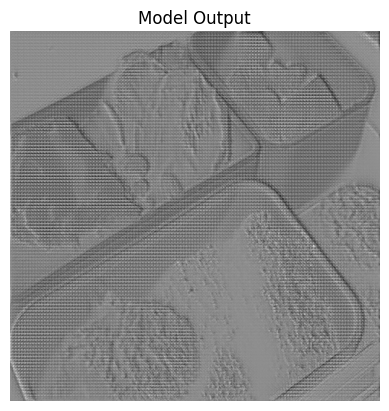

In [16]:
import matplotlib.pyplot as plt

with torch.no_grad():
    output = model(img_to_tensor)
    output_img = output.squeeze().cpu().numpy()

plt.imshow(output_img, cmap="gray")
plt.title("Model Output")
plt.axis("off")
plt.show()

Total Convolutional Layers: 15
Layer  | Out Ch  | In Ch  | Kernel   | Filters 
----------------------------------------------------------------------
0      | 64      | 3      | 3x3      | 64      
1      | 64      | 64     | 3x3      | 64      
2      | 128     | 64     | 3x3      | 128     
3      | 128     | 128    | 3x3      | 128     
4      | 256     | 128    | 3x3      | 256     
5      | 256     | 256    | 3x3      | 256     
6      | 512     | 256    | 3x3      | 512     
7      | 512     | 512    | 3x3      | 512     
8      | 256     | 512    | 3x3      | 256     
9      | 256     | 256    | 3x3      | 256     
10     | 128     | 256    | 3x3      | 128     
11     | 128     | 128    | 3x3      | 128     
12     | 64      | 128    | 3x3      | 64      
13     | 64      | 64     | 3x3      | 64      
14     | 1       | 64     | 1x1      | 1       

Found 15 convolutional layers



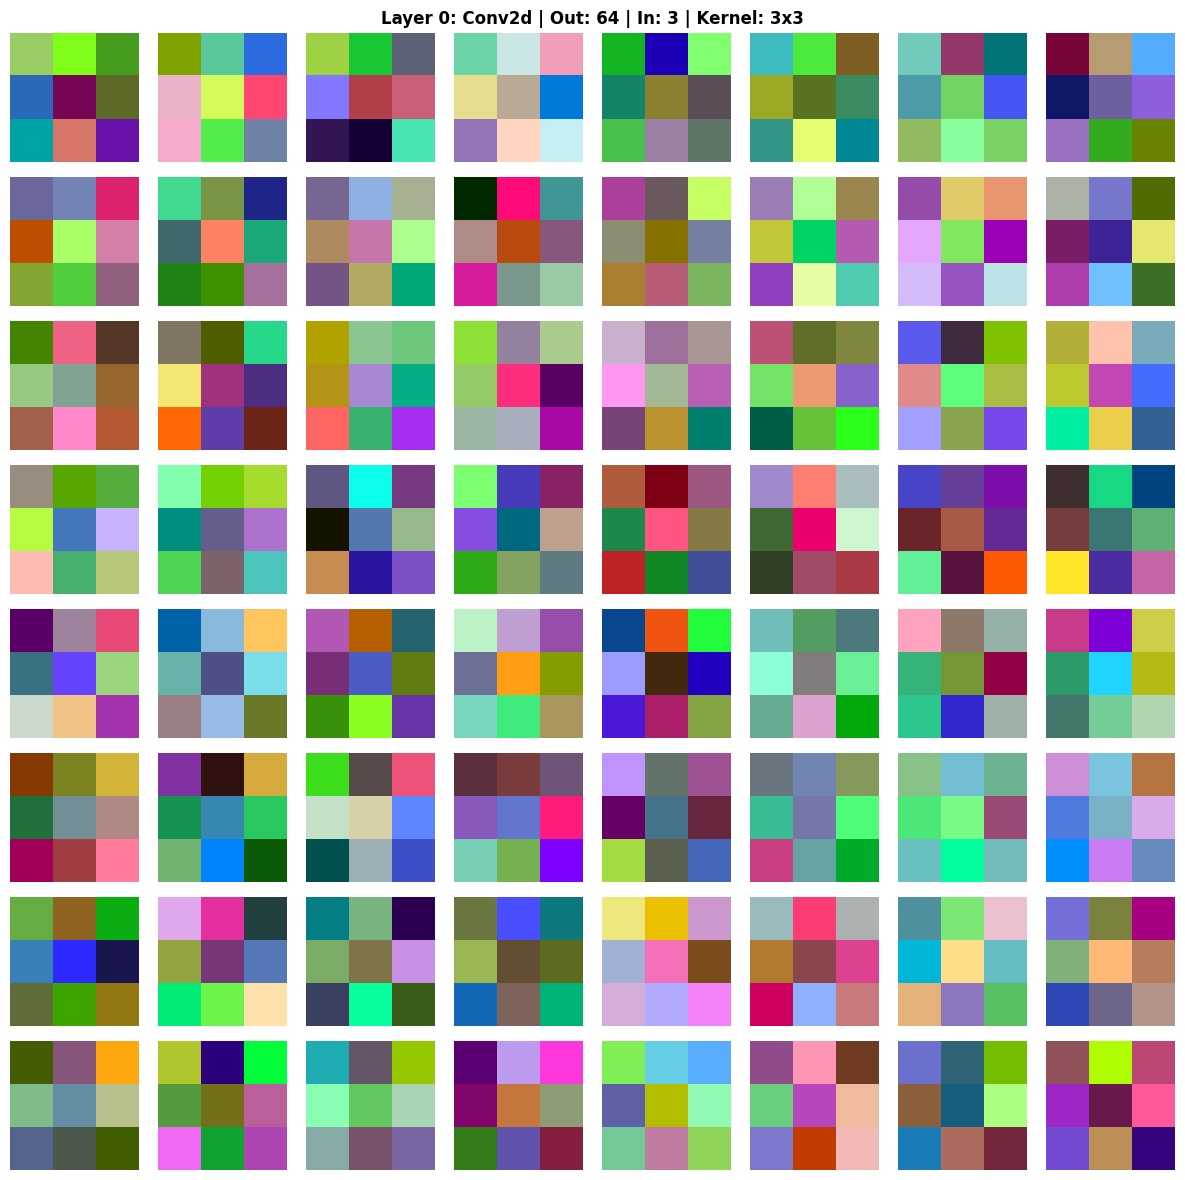

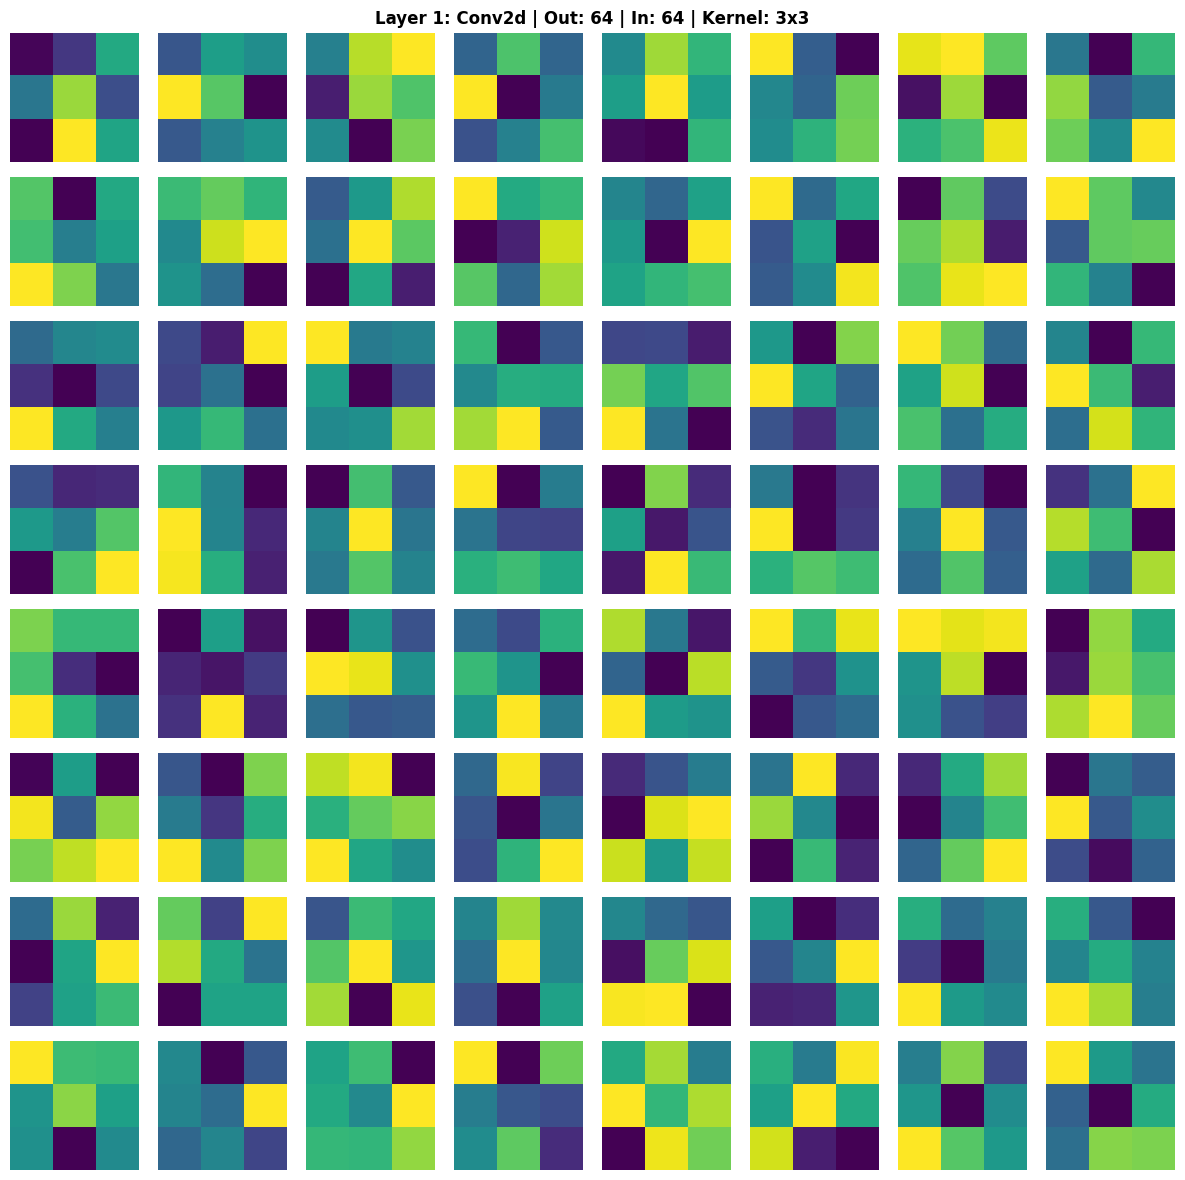

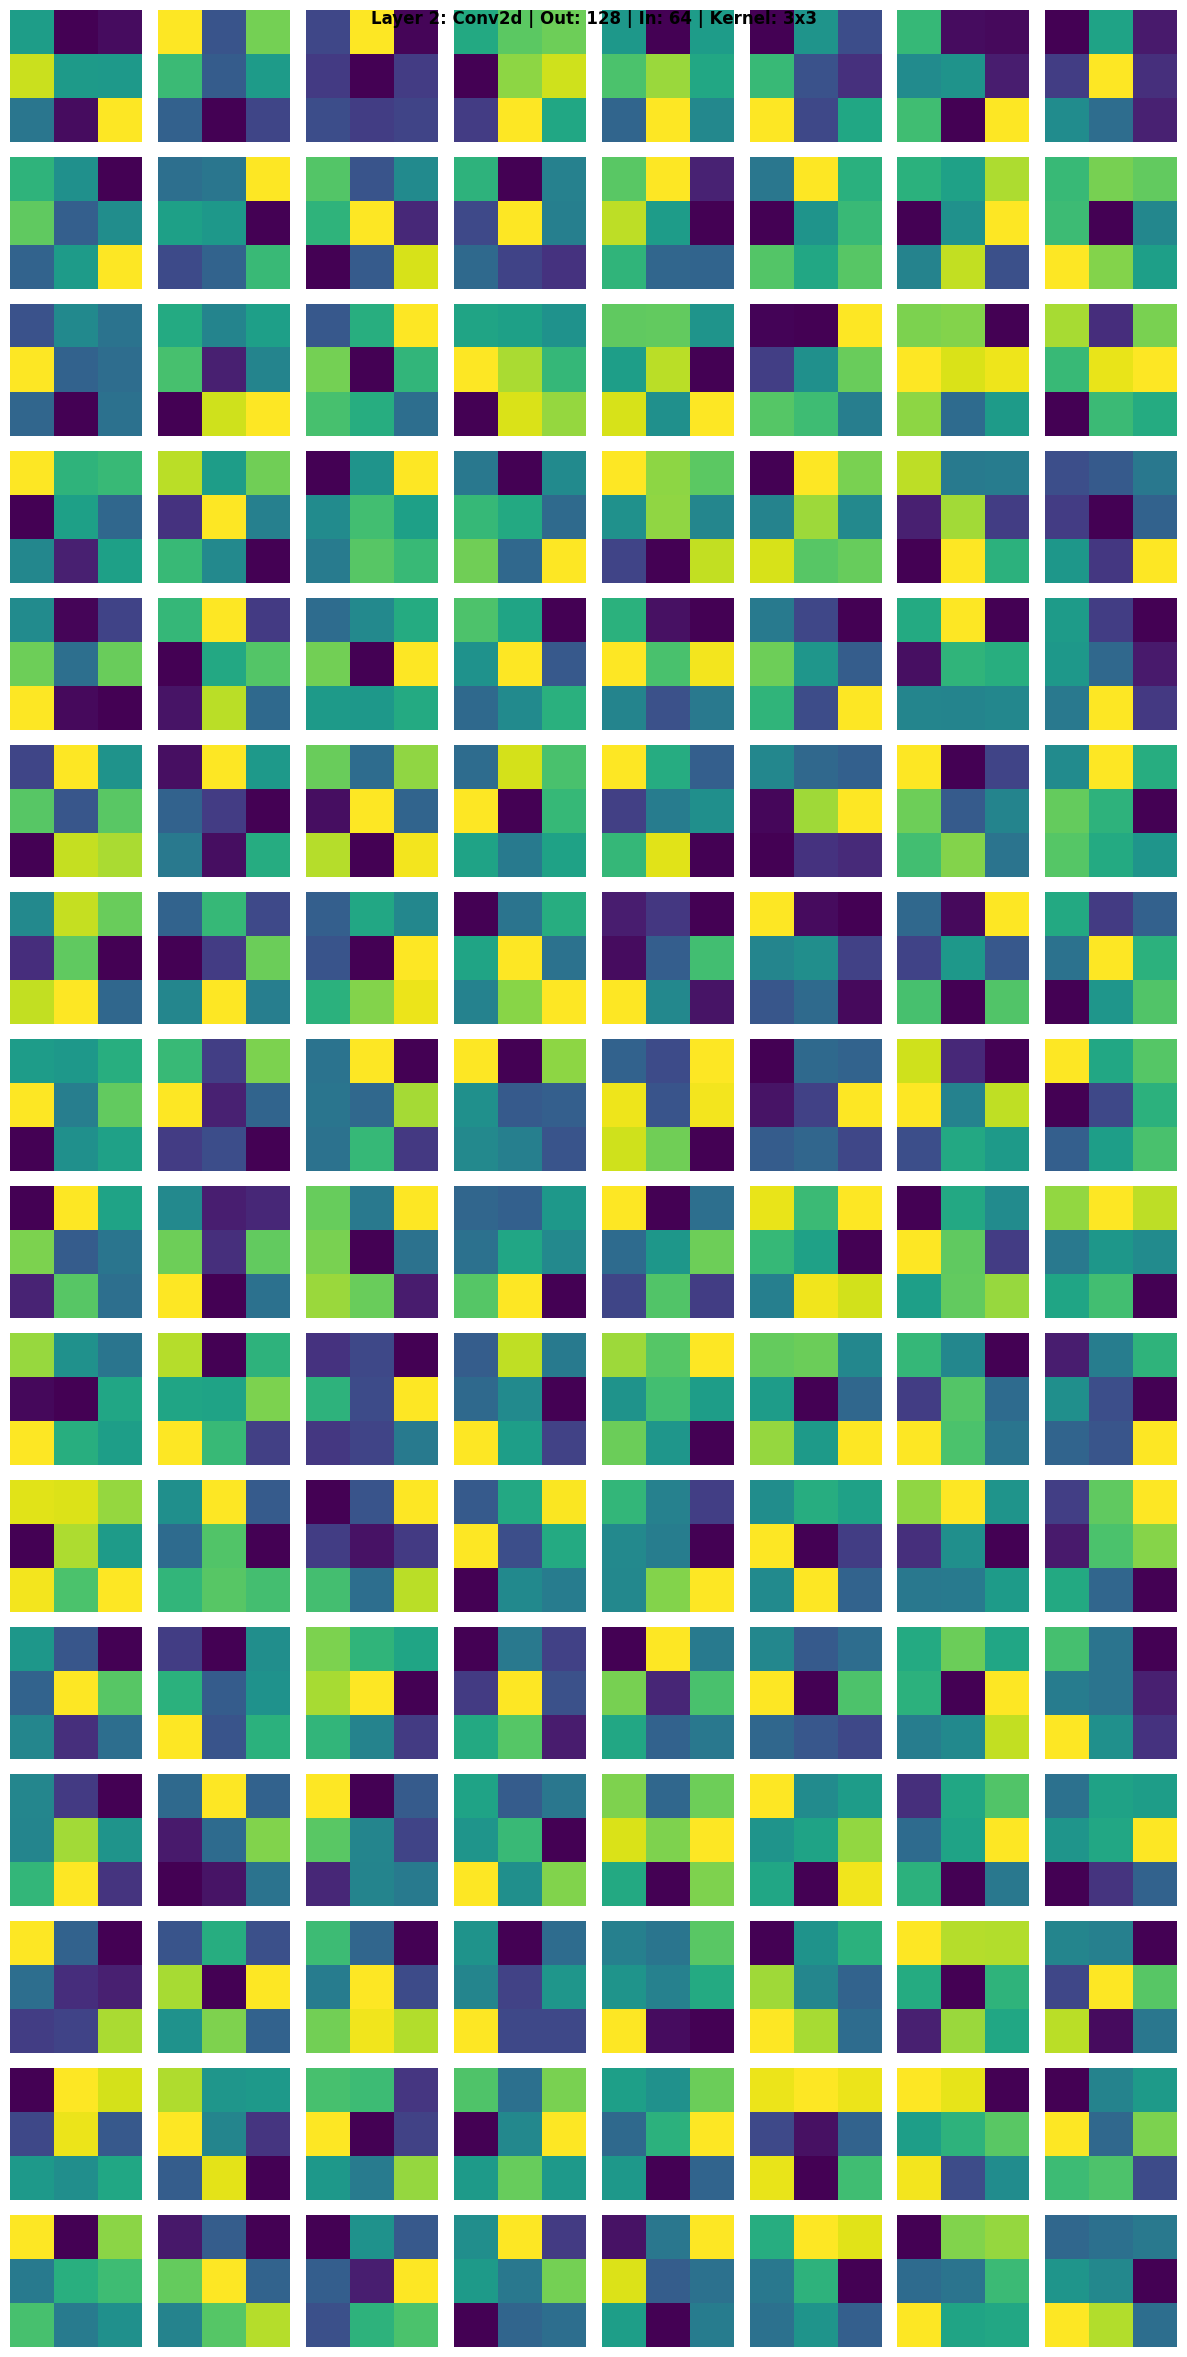

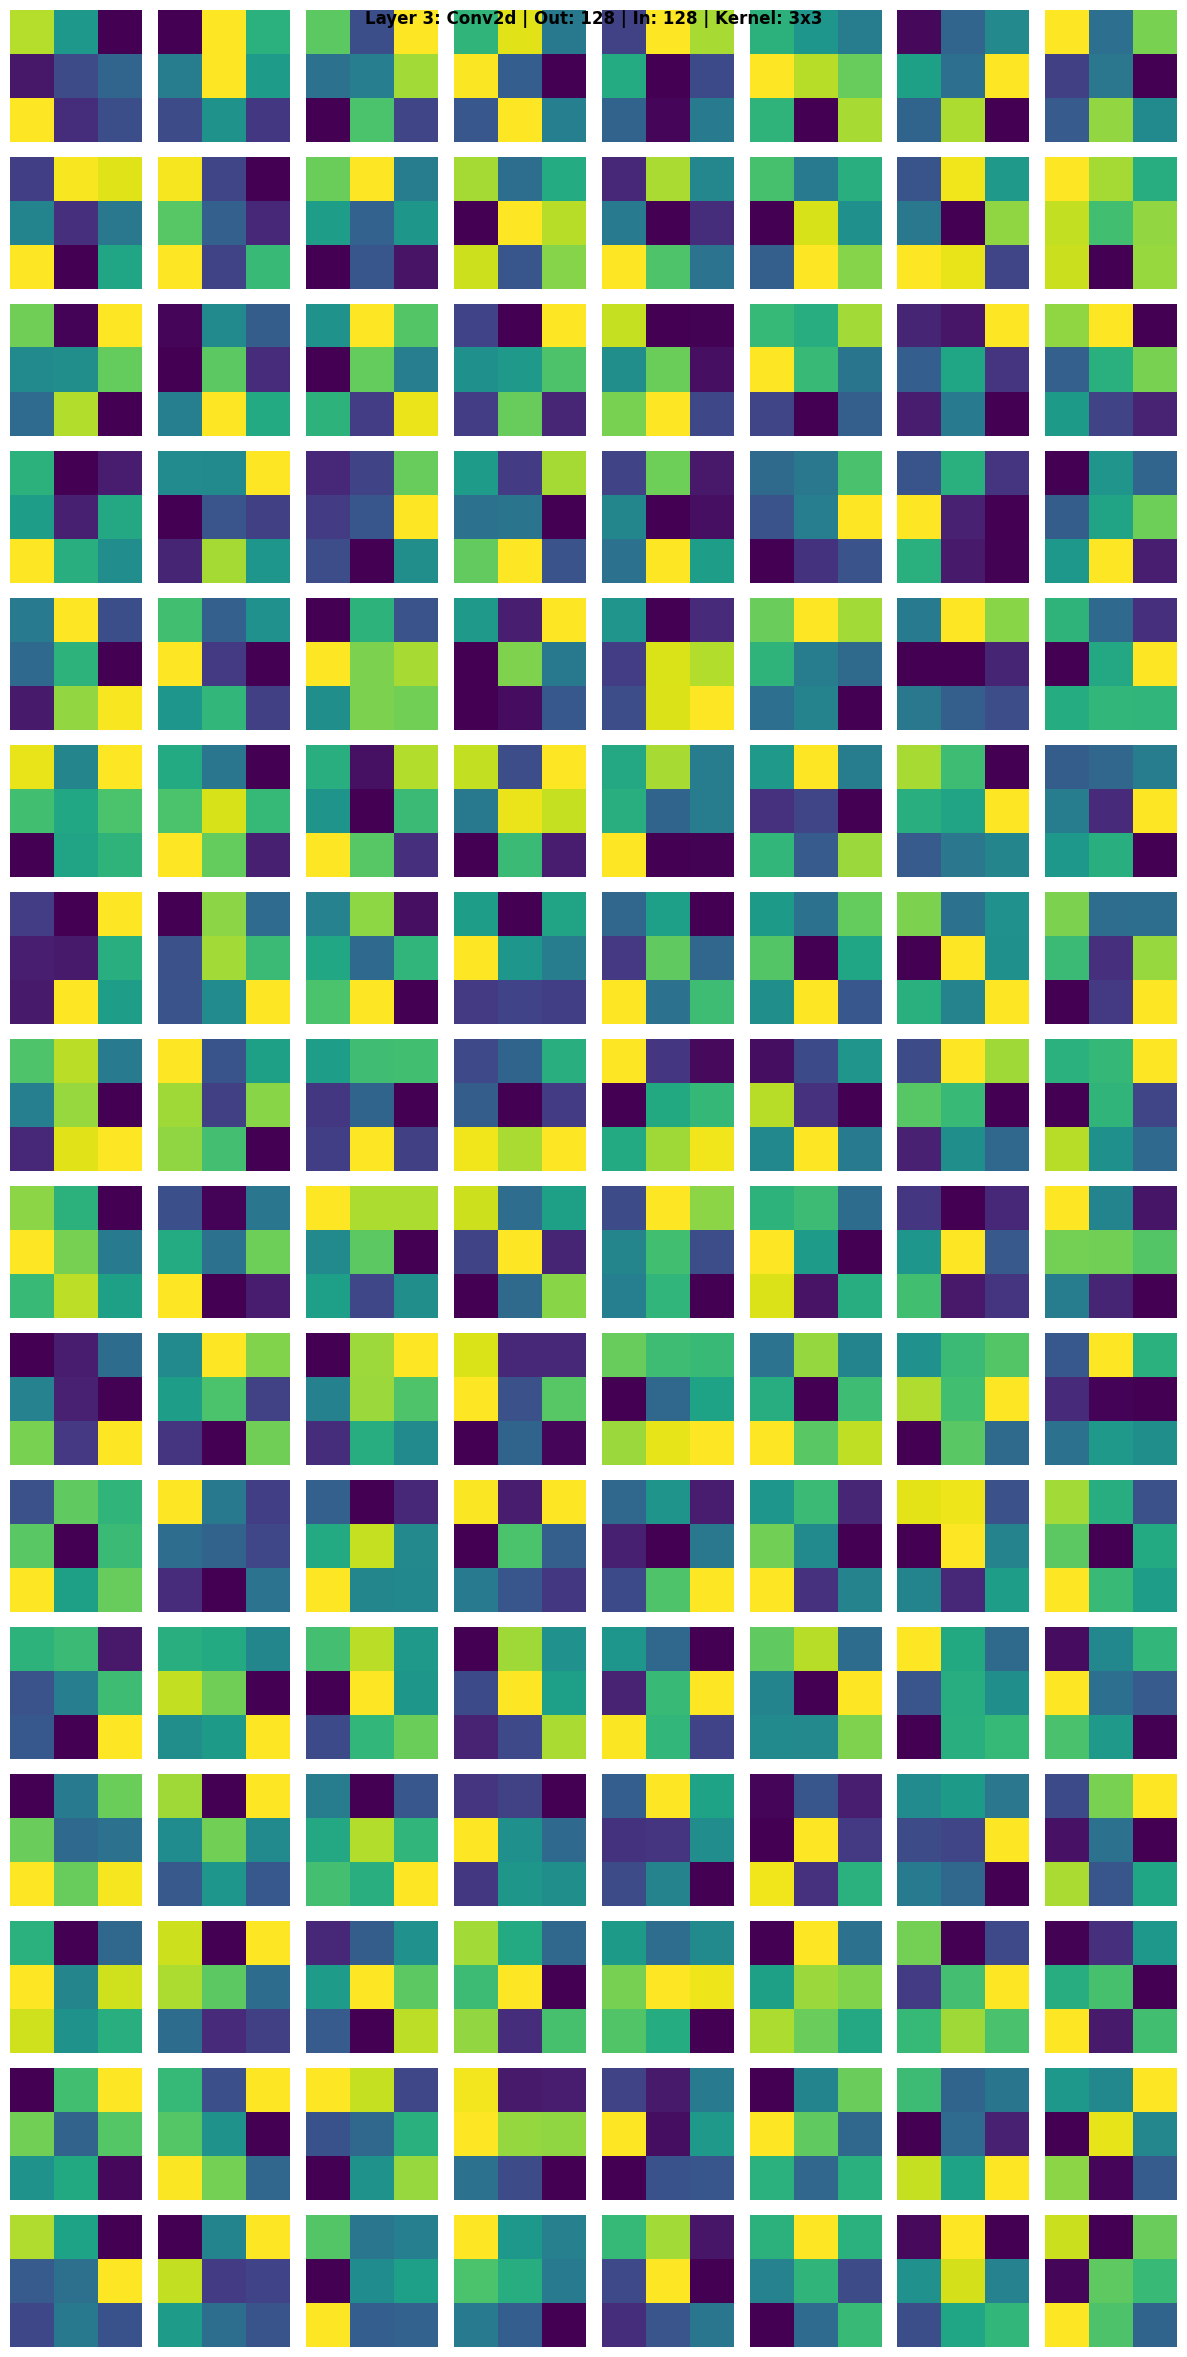

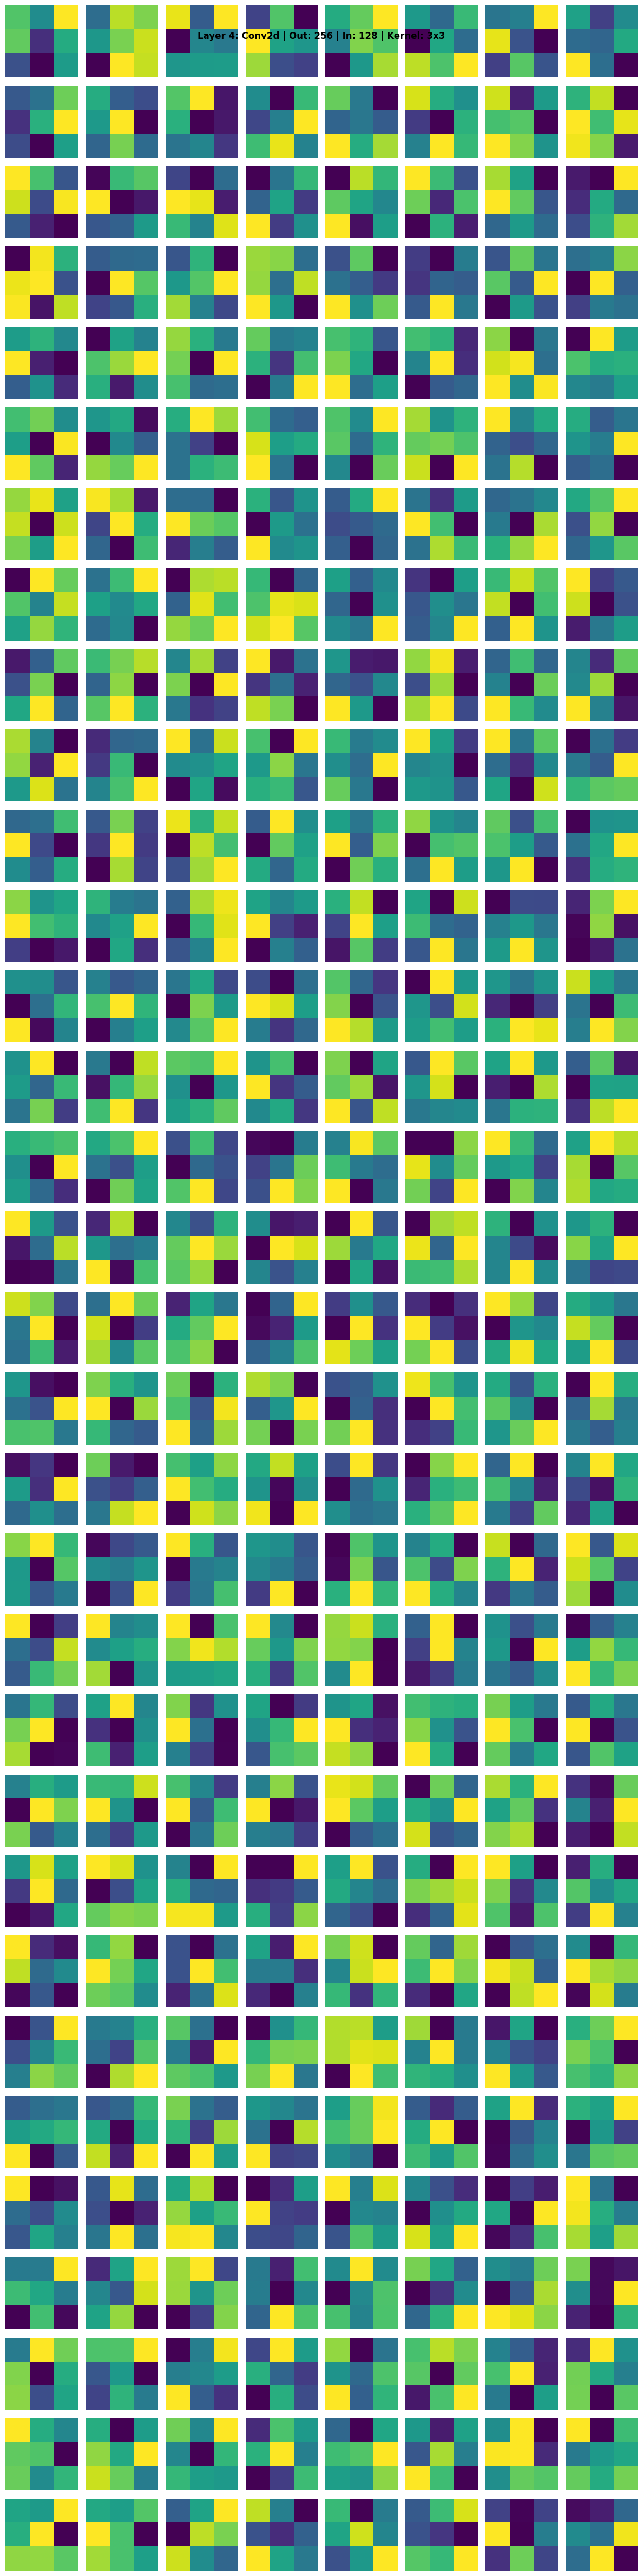

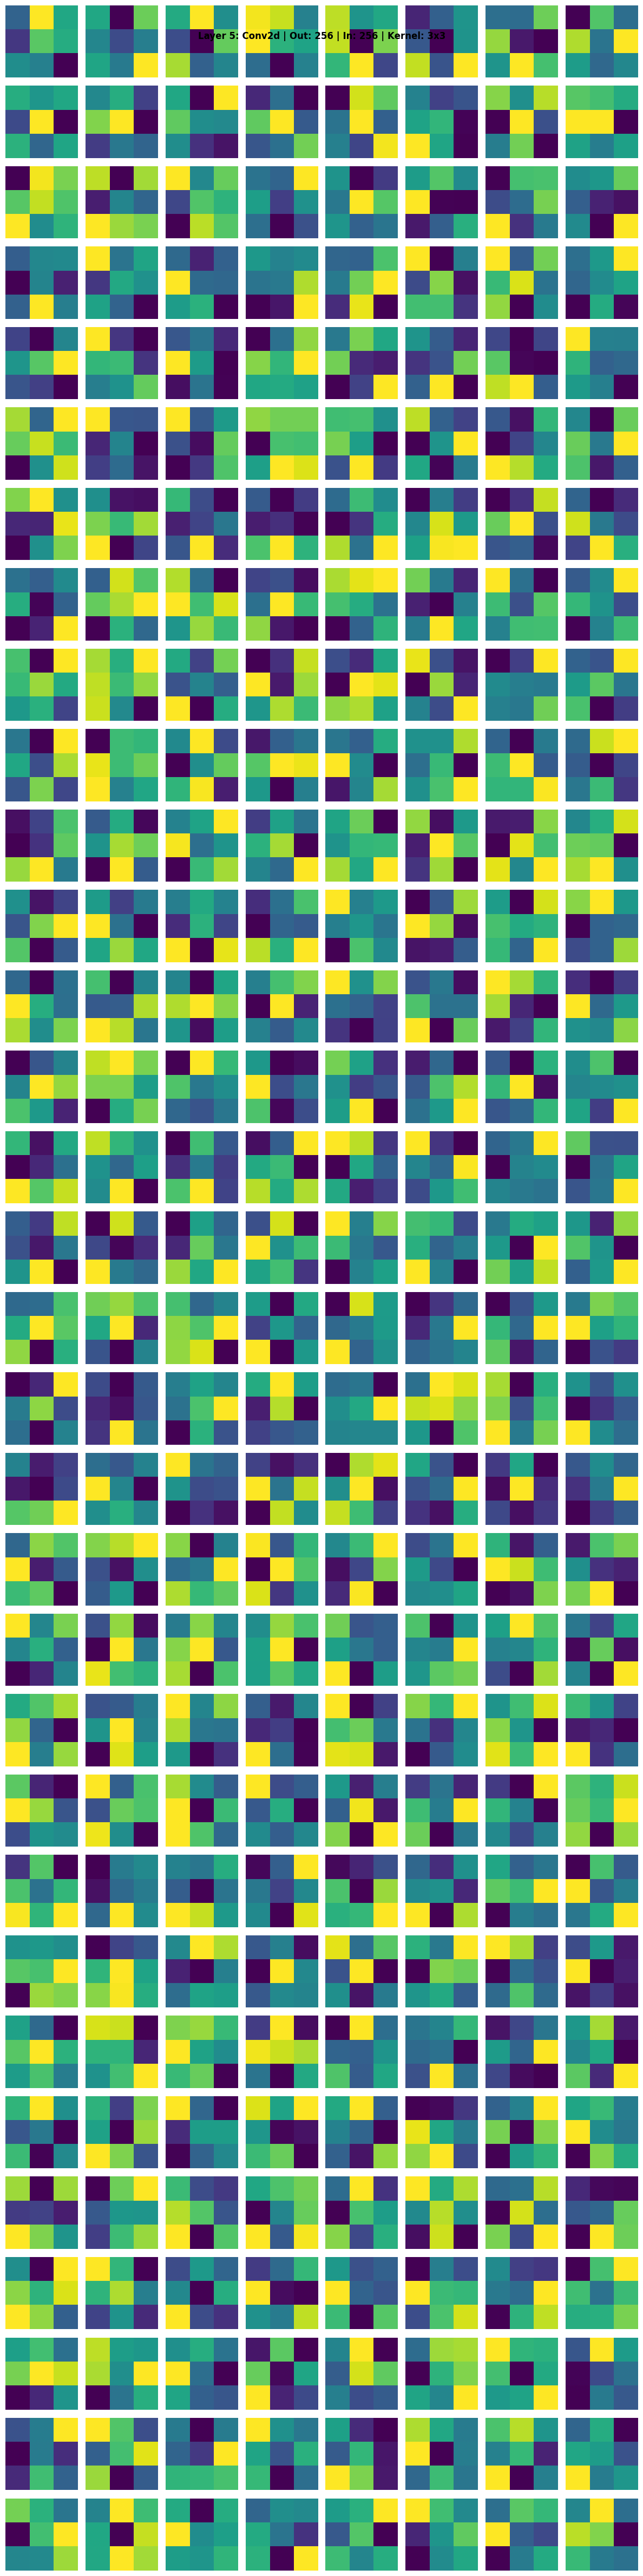

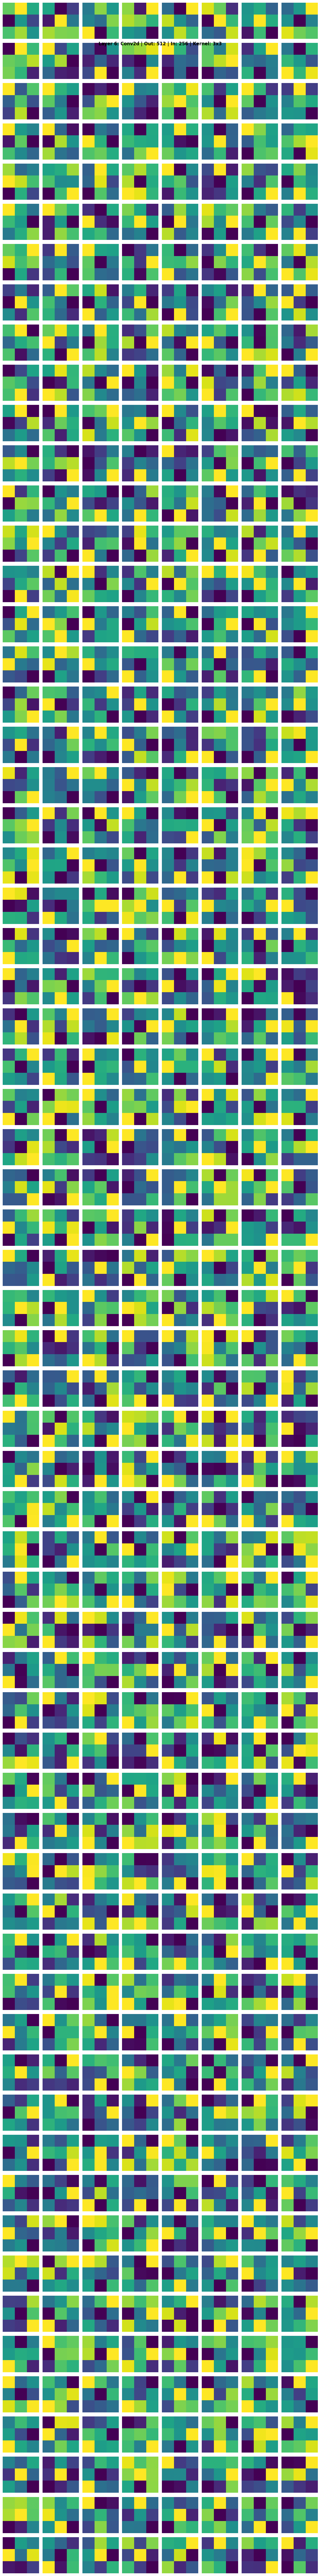

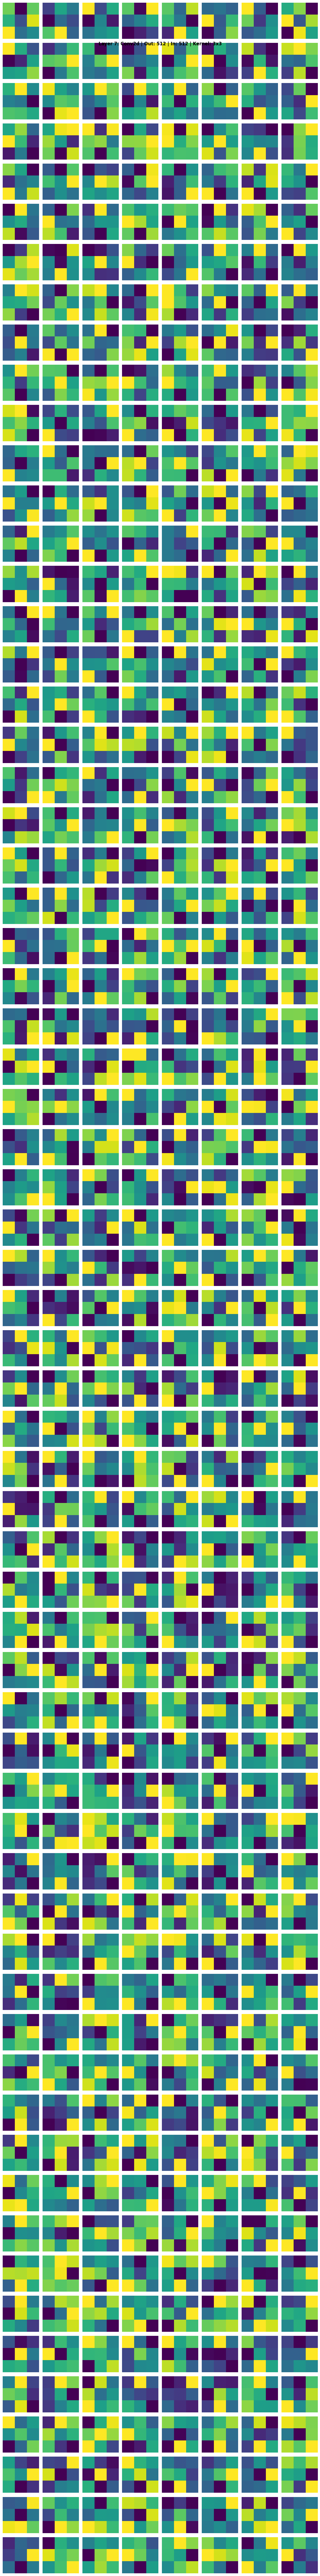

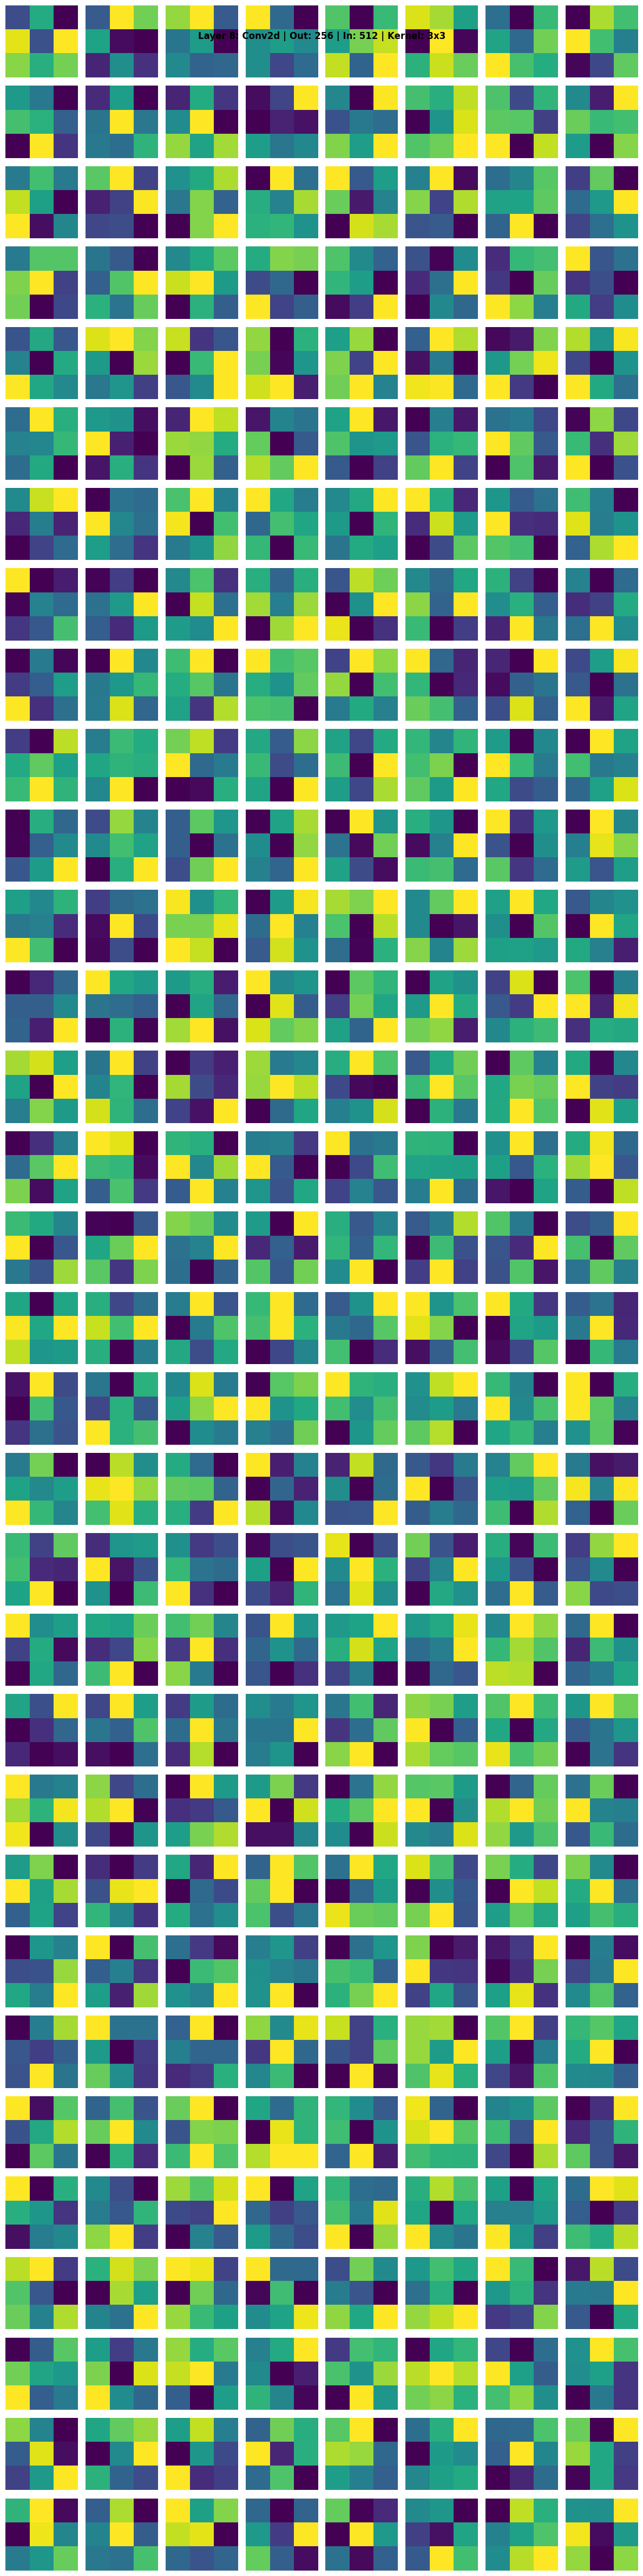

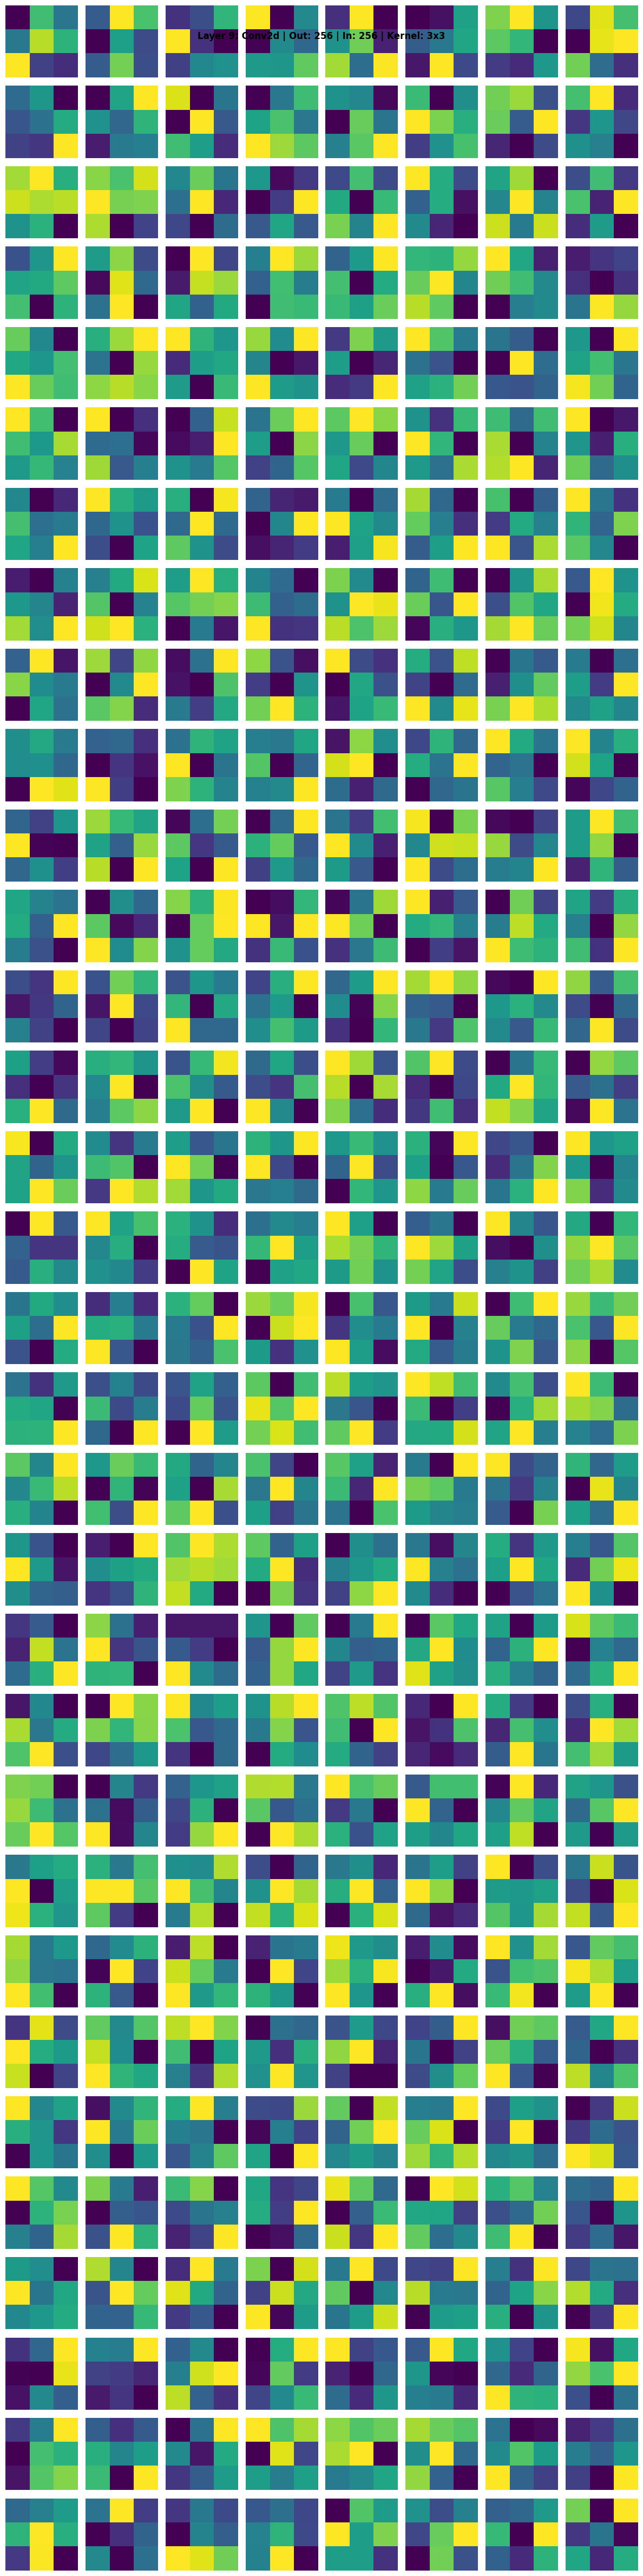

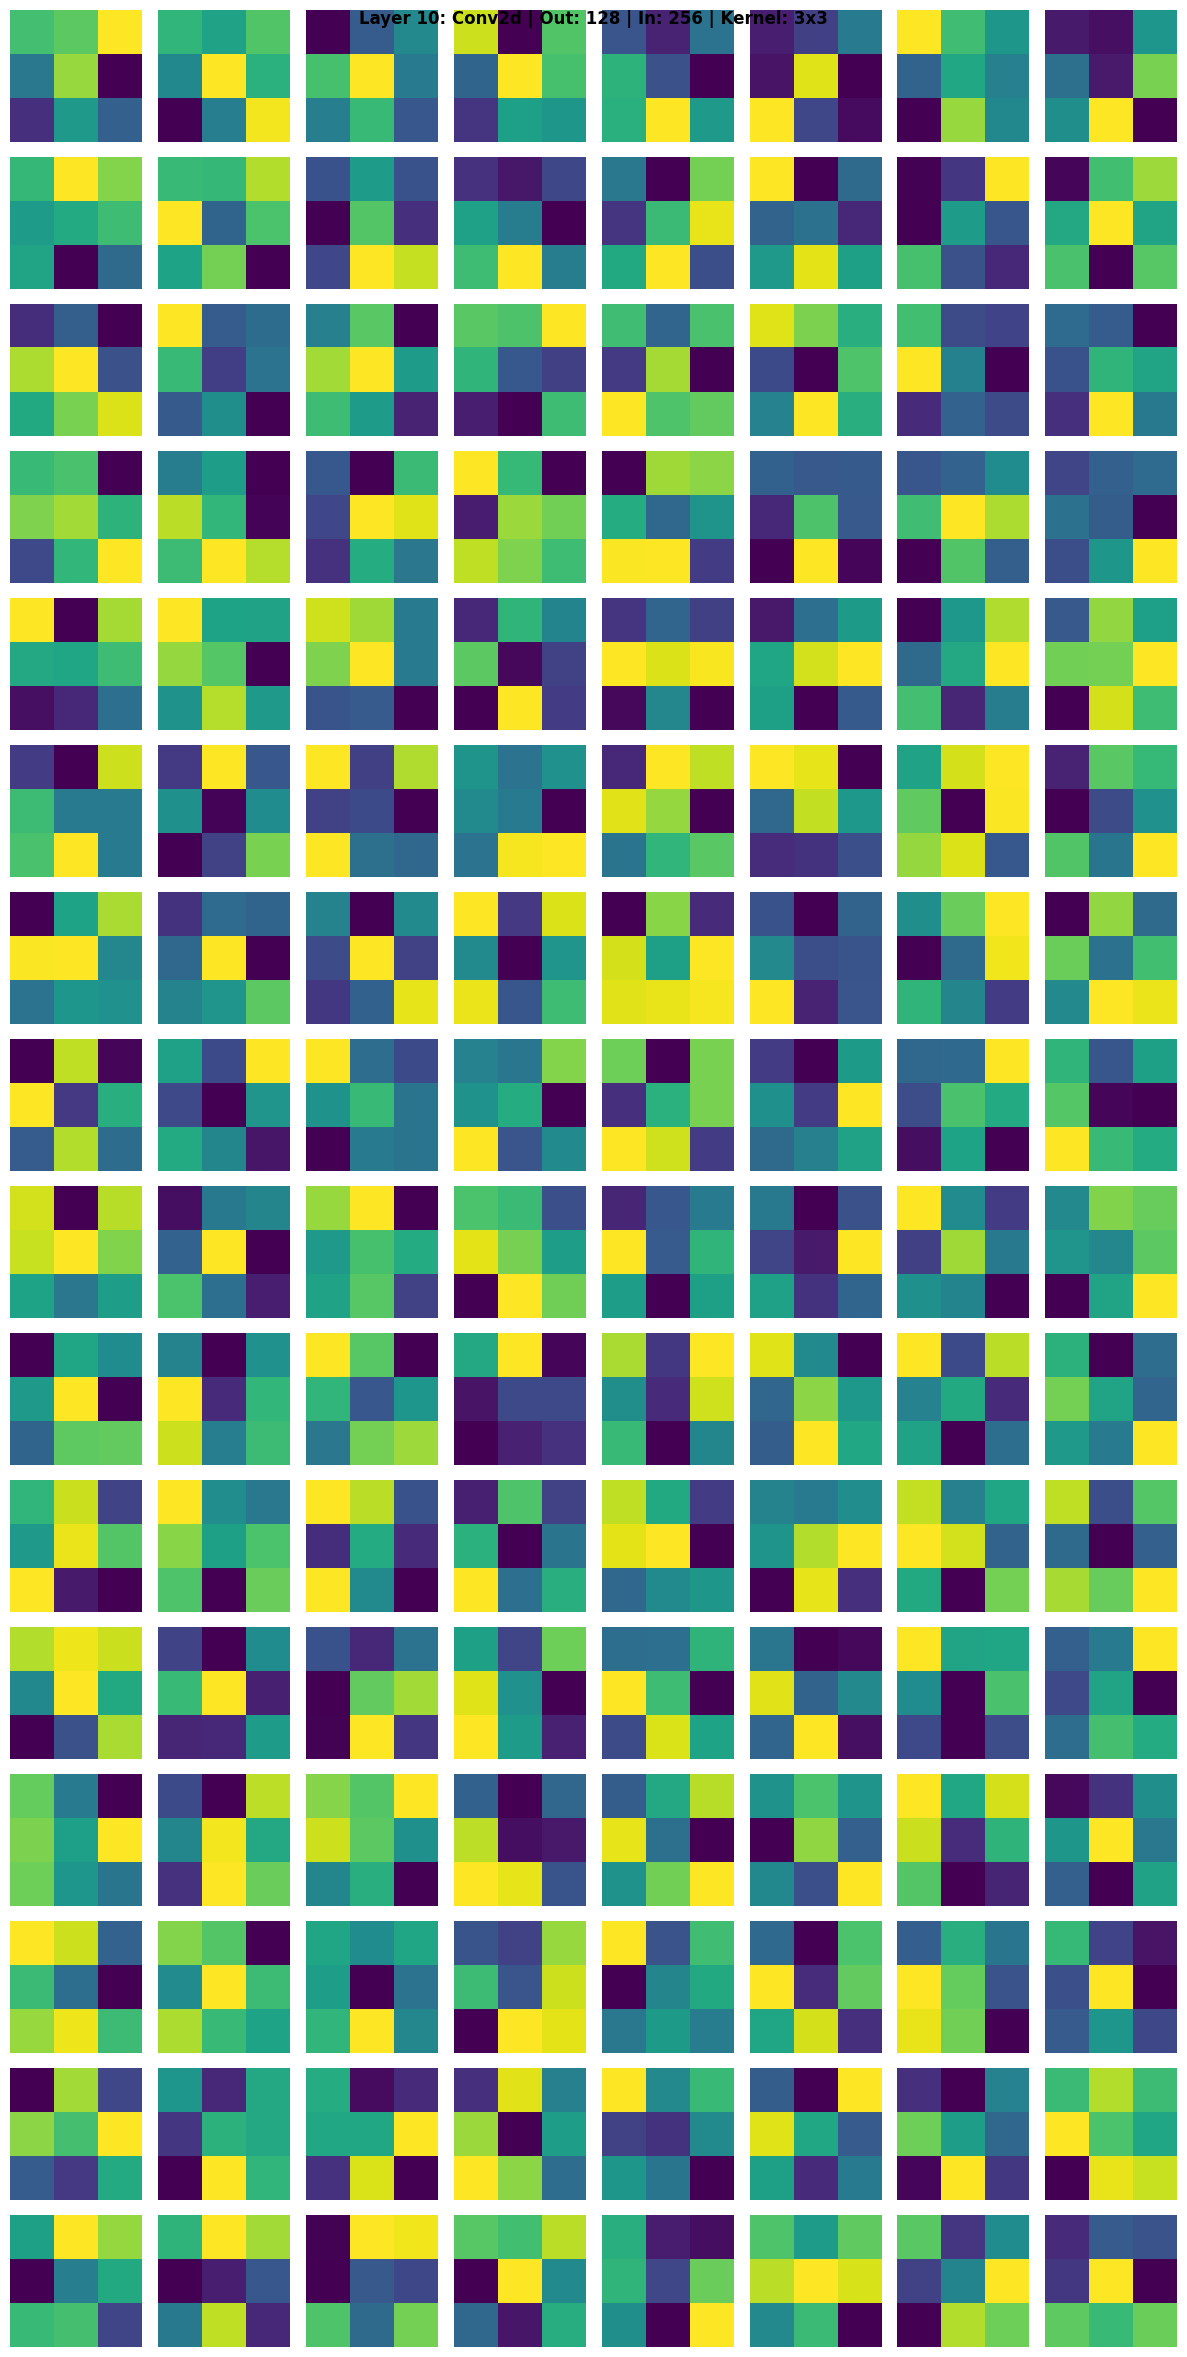

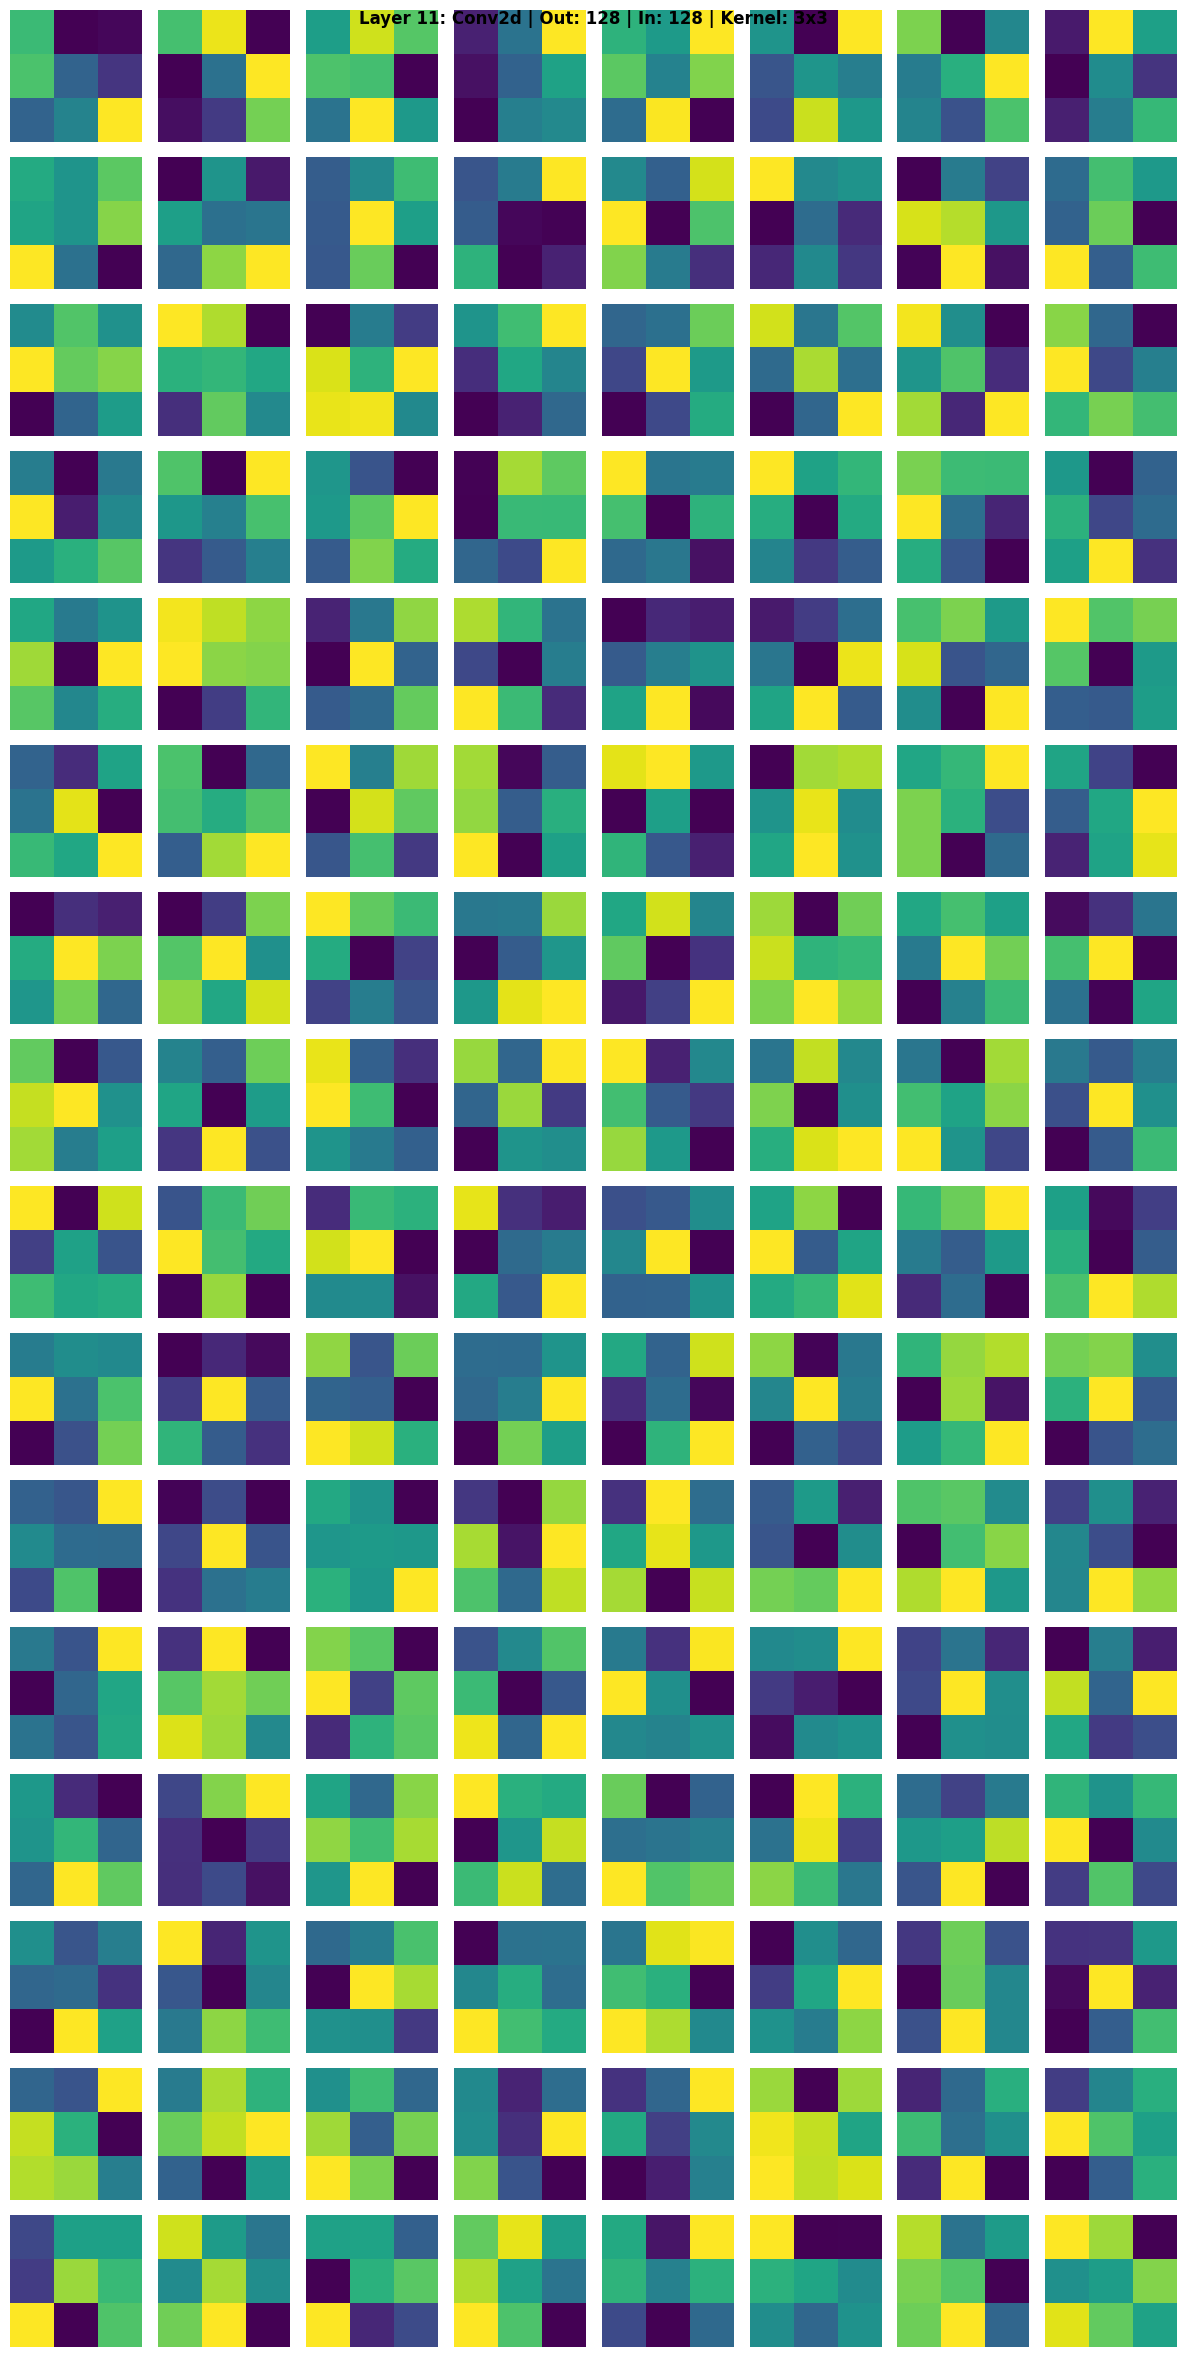

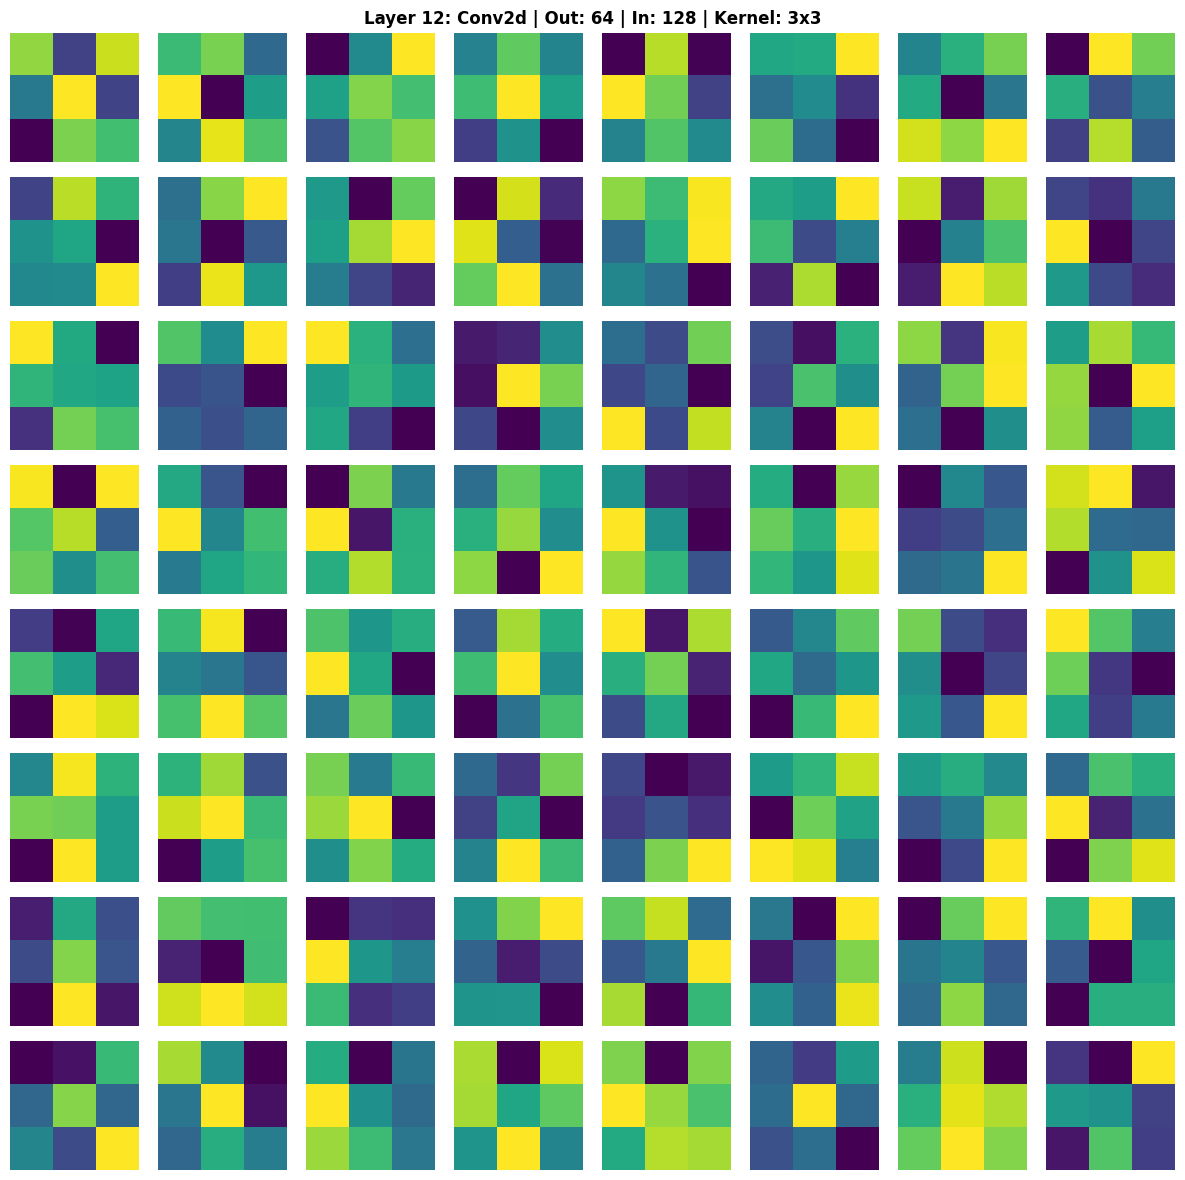

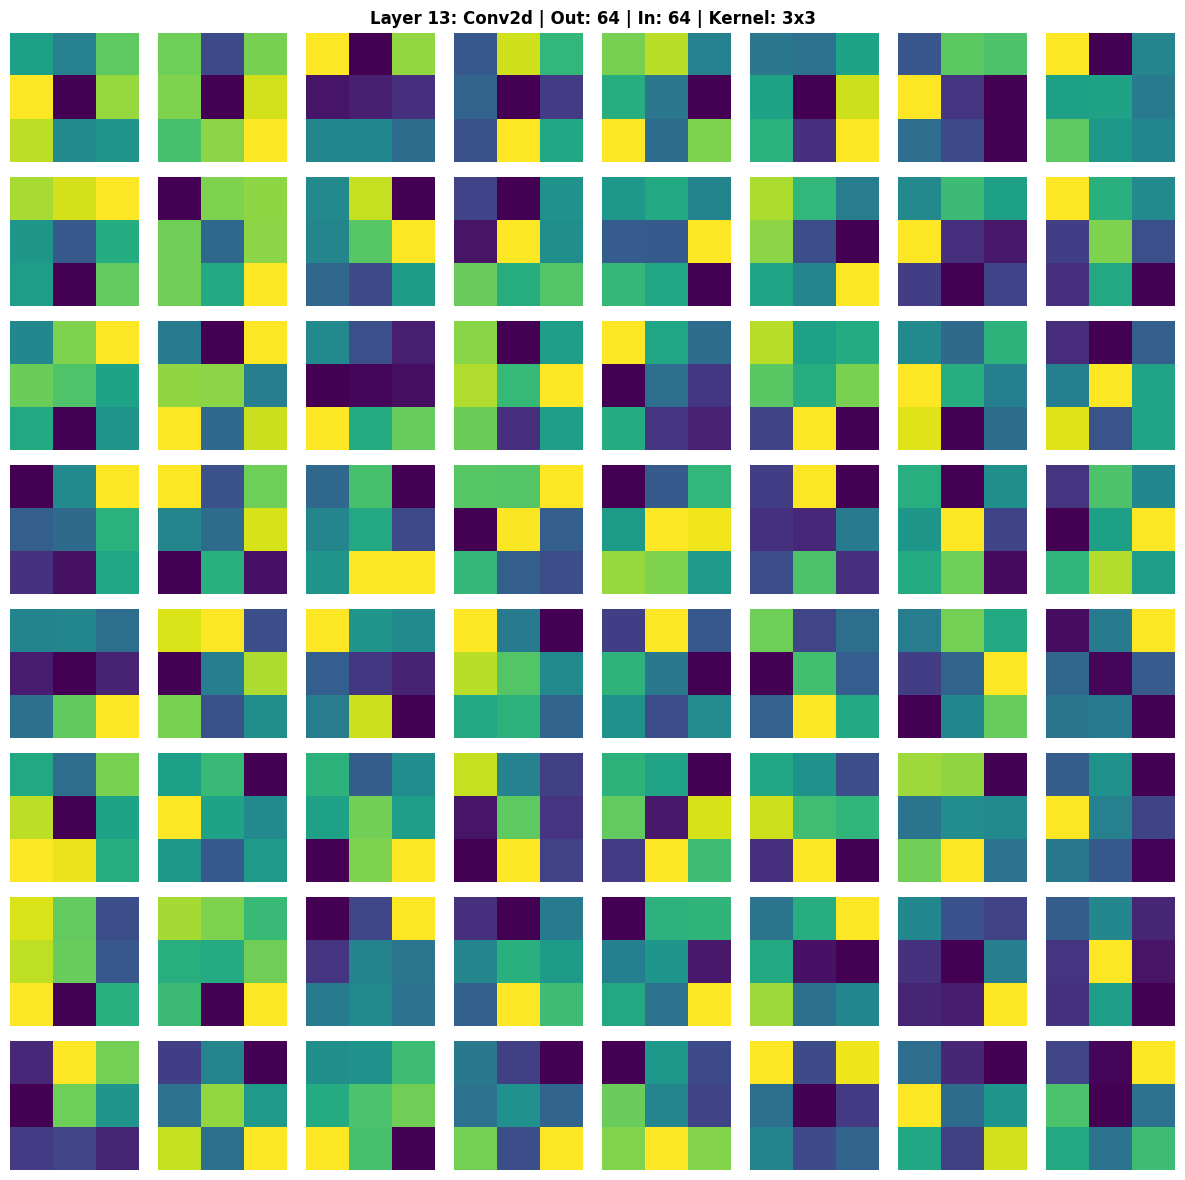

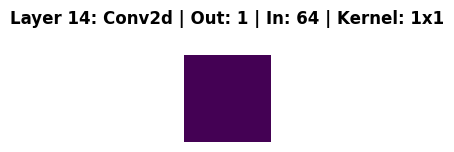

In [26]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

def visualize_conv_filters_notebook(model):
    """
    Notebook-friendly visualization of convolutional filters
    """
    conv_layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]
    
    print(f"Found {len(conv_layers)} convolutional layers\n")
    
    for layer_idx, layer in enumerate(conv_layers):
        filters = layer.weight.data.cpu().numpy()
        
        n_filters = filters.shape[0]
        n_channels = filters.shape[1]
        
        n_cols = min(8, n_filters)
        n_rows = (n_filters + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
        fig.suptitle(f'Layer {layer_idx}: Conv2d | Out: {filters.shape[0]} | In: {n_channels} | Kernel: {filters.shape[2]}x{filters.shape[3]}', 
                     fontsize=12, fontweight='bold')
        
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes.flatten()
        
        for i in range(n_filters):
            ax = axes[i]
            
            if n_channels == 1:
                filter_img = filters[i, 0]
                cmap = 'gray'
            elif n_channels == 3:
                filter_img = np.transpose(filters[i], (1, 2, 0))
                filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-8)
                cmap = None
            else:
                filter_img = filters[i].mean(axis=0)
                cmap = 'viridis'
            
            if cmap:
                vmin, vmax = filter_img.min(), filter_img.max()
                if vmax - vmin > 1e-8:
                    filter_img = (filter_img - vmin) / (vmax - vmin)
            
            ax.imshow(filter_img, cmap=cmap)
            ax.axis('off')
        
        for i in range(n_filters, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()



def layer_summary(model):
    """
    Quick summary of all conv layers
    """
    conv_layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]
    
    print(f"{'='*70}")
    print(f"Total Convolutional Layers: {len(conv_layers)}")
    print(f"{'='*70}")
    print(f"{'Layer':<6} | {'Out Ch':<7} | {'In Ch':<6} | {'Kernel':<8} | {'Filters':<8}")
    print(f"{'-'*70}")
    
    for i, layer in enumerate(conv_layers):
        w = layer.weight.data
        print(f"{i:<6} | {w.shape[0]:<7} | {w.shape[1]:<6} | {w.shape[2]}x{w.shape[3]:<6} | {w.shape[0]:<8}")
    
    print(f"{'='*70}\n")
    
layer_summary(model)
visualize_conv_filters_notebook(model, )
